In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score


X_train_clean = "./X_train_clean_v1.csv"

X_df = pd.read_csv(X_train_clean)


y_train_clean = "y_train_clean"

y_df = pd.read_csv(y_train_clean, header=None)

y_df['Target']=y_df[1].astype(int)


In [2]:
#Create a KNN model

# Establish independent and dependent variables
X = X_df[['Latitude','Longitude','DayofYear']]
y = y_df['Target']
    
    
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=42)

In [3]:
#Using smote hear to balance

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, ratio = 'minority')
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

X_train = X_train_res
y_train = y_train_res

In [4]:
#Second train test split on rebalanced data

X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=.3, random_state=42)


In [5]:
#Regularize/stnadardize your variables 
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)   

#Create model
knn = KNeighborsClassifier()
knn = knn.fit(X_train, y_train)    

print (knn.score(X_test, y_test))
print(np.mean(y_test))

0.8409851745576279
0.49928263988522237


In [6]:
#Function to get stats 

def evaluate_model(model):
   model.fit(X_train, y_train)
   y_pred = model.predict(X_test)
   cm = confusion_matrix(y_test, y_pred)
   print ('confusion matrix', confusion_matrix(y_test, y_pred))
   print ('accuracy', accuracy_score(y_test, y_pred))
   print ('sensitivity', recall_score(y_test, y_pred))
   print ('specificity', cm[1,1]/(cm[1,0]+cm[1,1]))

In [7]:
evaluate_model(knn)

confusion matrix [[1720  374]
 [ 291 1797]]
accuracy 0.8409851745576279
sensitivity 0.860632183908046
specificity 0.860632183908046


In [8]:
#Gridsearch

knn_params = {
    'n_neighbors':[500,3,50,90,15,21],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}

knn_gridsearch = GridSearchCV(knn, knn_params, cv=5, verbose=1, n_jobs=2)    
    
knn_gridsearch.fit(X_train, y_train)    
    
#Property	Use
knn_gridsearch.param_grid #Displays parameters searched over.
knn_gridsearch.best_score_ #Best mean cross-validated score achieved.
knn_gridsearch.best_estimator_ #Reference to model with best score. Is usable / callable.
print (knn_gridsearch.best_params_) #The parameters that have been found to perform with the best score.
#knn_gridsearch.grid_scores_ #Display score attributes with corresponding parameters.   


print ('best score', knn_gridsearch.best_score_)

#Assigning best estimator
#best_knn = knn_gridsearch.best_estimator_


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.1s


{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
best score 0.8810988109881098


[Parallel(n_jobs=2)]: Done 117 out of 120 | elapsed:   15.1s remaining:    0.4s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:   15.2s finished


In [9]:
#manually input gridsearch results from cell above

knn_gs = KNeighborsClassifier(n_neighbors=3, weights="distance", metric="manhattan")
knn_gs = knn.fit(X_train, y_train)    

In [10]:
evaluate_model(knn_gs)

confusion matrix [[1720  374]
 [ 291 1797]]
accuracy 0.8409851745576279
sensitivity 0.860632183908046
specificity 0.860632183908046


In [11]:
#AUC,ROC

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

proba_pairs = knn.predict_proba(X_test)
probas = [item[1] for item in proba_pairs]
roc_auc_score(y_test, probas)

0.9160133450068979

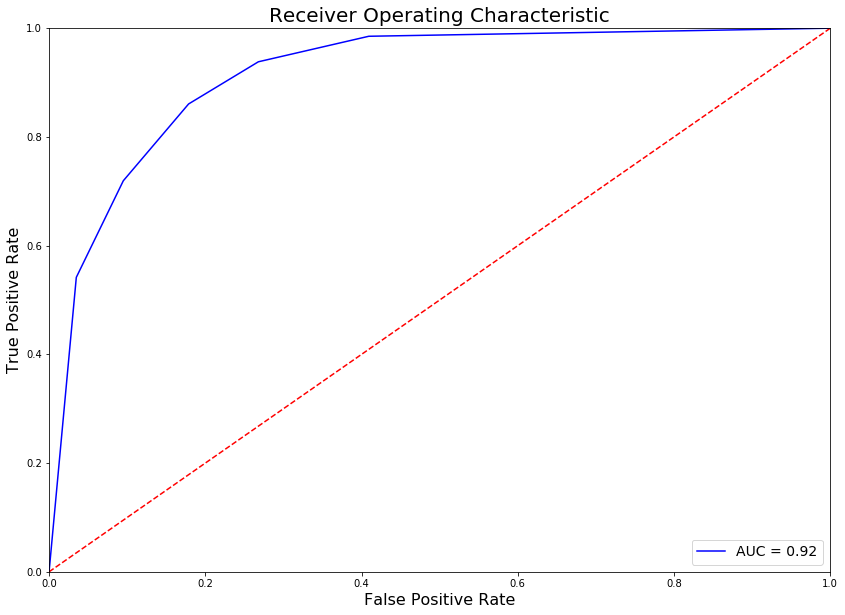

In [12]:
import matplotlib.pyplot as plt

#fpr = 1 - spec =(1-.86)
#tpr = sens = (1-.86)

tpr = .14
fpr = .14


fpr, tpr, threshold = roc_curve(y_test, probas)
roc_auc = auc(fpr, tpr)

fix, ax = plt.subplots(figsize=(14,10))

plt.title('Receiver Operating Characteristic', fontsize=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right', fontsize=14)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.show()

In [13]:
#Testing on X_test v1 data

X_test_clean = "./X_test_clean_v1.csv"

X_test_df = pd.read_csv(X_test_clean)

In [14]:
#Setting X and predicting probs on knn model made earlier

X_test_data = X_test_df[['Latitude','Longitude','DayofYear']]

kaggle_sub = knn.predict_proba(X_test_data)

In [15]:
#making dataframe out of probabilities
kag_sub_df=pd.DataFrame(kaggle_sub)

In [16]:
#Creating wnv column from where 1s are in the dataframe

kag_sub_df['WnvPresent']=kag_sub_df[[1]]

In [17]:
kag_sub_df.WnvPresent.sum() #checking how many 1s

0.0

In [18]:
kag_sub_df.drop(labels=[0,1], axis=1, inplace = True) #dropping the other two columns

In [19]:
kag_sub_df.index += 1  #adjusting index for kaggle submission

In [20]:
kag_sub_df.to_csv('prj4_kag_sub.csv')  #Creating csv file